In [1]:
import geopandas
import contextily
import meteostat
import shapely
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib import colormaps
import matplotlib.lines as mlines


def to_meteostat_point(point: shapely.Point, alt: int = None) -> meteostat.Point:
    return meteostat.Point(point.y, point.x, alt)

In [2]:
polygons_path = "../data/processed/SAIS_areaPolygons.geojson"

gdf = geopandas.read_file(polygons_path)
polygons = gdf.set_index("name").to_dict("index")

# gdf.to_crs(epsg=27700, inplace=True)
# gdf["area (km^2)"] = gdf.area / 1000000
# gdf["centroid"] = gdf.centroid

gdf_dict = gdf.set_index("name").to_dict("index")
gdf_dict = {k: v["geometry"] for k, v in gdf_dict.items()}

In [ ]:
centroid = gdf_dict["Creag Meagaidh"].centroid


meteostat_retriever = meteostat.Stations().nearby(centroid.y, centroid.x, 200000)
meteostat_stations = meteostat_retriever.fetch()
meteostat_stations = geopandas.GeoDataFrame(meteostat_stations, geometry=geopandas.points_from_xy(meteostat_stations.longitude, meteostat_stations.latitude))


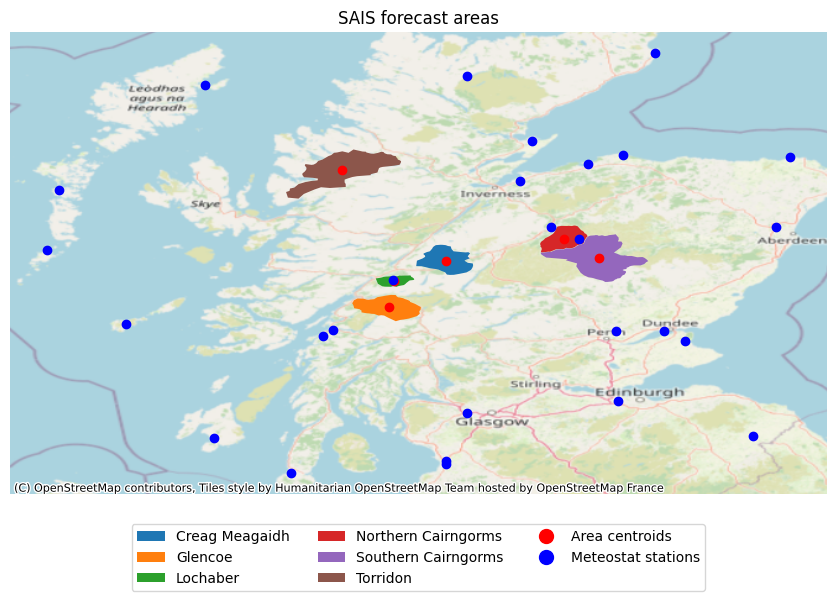

In [ ]:

cmap = colormaps["tab10"]

fig, ax = plt.subplots(figsize=(12,6))
pmarks = []
i = 0
for label, data in gdf.groupby("name"):
    color = cmap(i)
    data.plot(ax=ax, color=color)
    pmarks.append(Patch(facecolor=color, label=label))
    i+=1

gdf.geometry.centroid.plot(ax=ax, color="red")
meteostat_stations.geometry.plot(ax=ax, color="blue")

handles, _ = ax.get_legend_handles_labels()
pmarks.append(mlines.Line2D([], [], color="red", marker="o", linestyle="None", markersize=10, label="Area centroids"))
pmarks.append(mlines.Line2D([], [], color="blue", marker="o", linestyle="None", markersize=10, label="Meteostat stations"))

ax.legend(handles=[*handles,*pmarks], loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=3)

contextily.add_basemap(ax, crs=gdf.crs.to_string())
plt.title("SAIS forecast areas")
plt.axis("off")
plt.show()


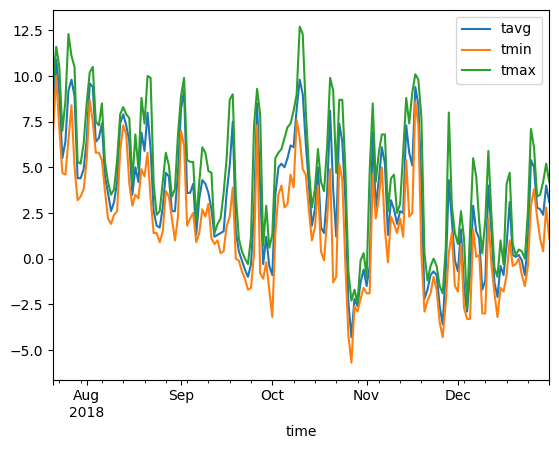

In [6]:
# Import Meteostat library and dependencies
from datetime import datetime
import matplotlib.pyplot as plt
from meteostat import Daily

# Set time period
start = datetime(2018, 1, 1)
end = datetime(2018, 12, 31)

# Create Point for Vancouver, BC
region = to_meteostat_point(gdf_dict["Creag Meagaidh"].centroid)

# Get daily data for 2018
data = Daily(region, start, end)
data = data.fetch()

# Plot line chart including average, minimum and maximum temperature
data.plot(y=["tavg", "tmin", "tmax"])
plt.show()
